## Implementation of an object detector 
In this notebook, you will need to implement an CNN based object detector to detect specific objects in given images.

You will find the resources in folder 'src'. It contains the image set for training and testing, the groundtruth of the images, and a folder to place your parameters (weights).

<img src="pics/0__1_.jpg" alt="Biker" />

This task is divided into three sections. This notebook contains only the first section. 

- In the first section, you will load weights to a pre-defined neural network


In [1]:
from __future__ import absolute_import, division, print_function

import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)
print(tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image, ImageDraw

/home/msiot/msiot/tf-xavier/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/msiot/msiot/tf-xavier/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/msiot/msiot/tf-xavier/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/msiot/msiot/tf-xavier/lib/python3.6/site-packages/tensorflow/

1.13.1
2.2.4-tf


Check the devices available on your machine:

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9630106568676036726
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1470094002224617339
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17072509325990838511
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7760986727
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5952765345604152478
physical_device_desc: "device: 0, name: Xavier, pci bus id: 0000:00:00.0, compute capability: 7.2"
]


Before we do anything, we need to import the image data.

In [3]:
'''
Load groundtruch
'''
import json
with open('src/groundtruth.txt', 'r') as file:
    lines = json.load(file)

print('There are %d image-label pair in the entire set' %(len(lines)))
print('First entry looks like this:')
print(lines[0])

There are 996 image-label pair in the entire set
First entry looks like this:
['src/images/932.jpg', [0.48984375, 0.5055555555555555, 0.0328125, 0.08333333333333333]]


Now, we need to pick ramdomly from the data set to put aside a subset of images for testing. The model **should not** see this subset of images while training.

In [4]:
'''
This function converts the image into the input type.
'''
def load_input(path):
    img = Image.open(path)
    img = img.resize((320,160))
    input_img = np.asarray(img).astype(np.float32)
    input_img = (input_img/255 - 0.5)/0.25
    return input_img[np.newaxis,:]

'''
This function draws the rectangle around the object
'''
def show_image(image, box):
    img = Image.open(image)
    
    box_top_left = (int((box[0] - box[2]/2)*640), int((box[1] + box[3]/2)*360))
    box_bot_right = (int((box[0] + box[2]/2)*640), int((box[1] - box[3]/2)*360))

    draw = ImageDraw.ImageDraw(img)
    draw.rectangle((box_top_left, box_bot_right), outline = (255,0,0))

    plt.figure(1, figsize = (16, 9), dpi =300)
    plt.imshow(img)
    plt.show()
    
'''
This is the function to get the predict box (x,y,w,h)
'''
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def get_box(output):
    anchors = [1.4940052559648322, 2.3598481287086823, 4.0113013115312155, 5.760873975661669]
    h = output.shape[2]
    w = output.shape[3]
    output = output.reshape(2,5,800).transpose(1,0,2).flatten().reshape(5,1600)
    grid_x = np.tile(np.tile(np.linspace(0,w-1,w),h).reshape(h,w),(2,1,1)).flatten()
    grid_y =np.tile(np.tile(np.linspace(0,h-1,h),w).reshape(w,h).T,(2,1,1)).flatten()
    xs = sigmoid(output[0]) + grid_x
    ys = sigmoid(output[1]) + grid_y
    anchor_w = np.zeros(1600)
    anchor_h = np.zeros(1600)
    anchor_w[0:800] = anchors[0]
    anchor_w[800:1600] = anchors[2]
    anchor_h[0:800] = anchors[1]
    anchor_h[800:1600] = anchors[3]
    ws = np.exp(output[2]) * anchor_w
    hs = np.exp(output[3]) * anchor_h
    ind = np.argmax(output[4])
    bcx = xs[ind]
    bcy = ys[ind]
    bw = ws[ind]
    bh = hs[ind]
    box = [bcx/w, bcy/h, bw/w, bh/h]
    return box

In [5]:
import pickle
with open ('src/params_sets_alt', 'rb') as fp:
    weights_list = pickle.load(fp, encoding='latin1')

## section 1
First, a pre-defined keras model is given. Your task is to play with the training configurations and explore their effects on the training performance (speed, accuracy, etc.)

In [6]:
#this is the model for the testing part
model = tf.keras.models.Sequential([
    #first dw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1), use_bias=False, input_shape=(160, 320, 3)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    layers.Conv2D(48, (1, 1), padding='same', use_bias=False, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    #maxpooling
    layers.MaxPool2D(strides =(2, 2)),
    #second dw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1), use_bias=False),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    layers.Conv2D(96,(1,1), padding='same', use_bias=False, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    #maxpooling
    layers.MaxPool2D(strides =(2, 2)),
    #third dw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1), use_bias=False),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    layers.Conv2D(192, (1, 1), padding='same', use_bias=False,strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    #maxpooling
    layers.MaxPool2D(strides=(2, 2)),
    #fourth dw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1), use_bias=False),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    layers.Conv2D(384, (1, 1), padding='same', use_bias=False, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    #fifth dw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1), use_bias=False),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    layers.Conv2D(512, (1, 1), padding='same',use_bias=False, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5, trainable=False),
    layers.ReLU(4.0),
    #output
    layers.Conv2D(10,(1,1), padding='same',use_bias=False,strides=(1, 1)),
    ]
)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.trainable = False

### Load the model

In [8]:
model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model_layers = [layer for layer in model.layers]
model.summary()
cnt = 0
bn_weights = []
for layer in model_layers:
    layer_name = layer.get_config()['name']
    if 're_lu' not in layer_name and 'max_pooling2d' not in layer_name:
        cnt += 1
        if 'batch' in layer_name:
            bn_weights.append(weights_list[cnt])
        layer.set_weights(weights_list[cnt])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC (None, 160, 320, 3)       27        
_________________________________________________________________
batch_normalization_v1 (Batc (None, 160, 320, 3)       12        
_________________________________________________________________
re_lu (ReLU)                 (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 320, 48)      144       
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 160, 320, 48)      192       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 160, 320, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 160, 48)       0         
__________

### Correct weights:
```
[0.8880645155906677, 0.6772263944149017, 0.02124013871572325, 0.058586649582813566]
```

In [9]:
input_img = load_input('src/images/2.jpg')
print(input_img.shape)
output = model.predict(input_img).transpose(0,3,1,2)
print(get_box(output))

(1, 160, 320, 3)
[0.8881894007325173, 0.6775639593601227, 0.021205863504447385, 0.05896041632910892]


### Compute IoU

In [10]:
# define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

def bbox_iou(boxA, boxB):
    
    x_a_ll = boxA[0] - boxA[2]/2
    y_a_ll = boxA[1] - boxA[3]/2
    x_a_ur = boxA[0] + boxA[2]/2
    y_a_ur = boxA[1] + boxA[3]/2
    x_b_ll = boxB[0] - boxB[2]/2
    y_b_ll = boxB[1] - boxB[3]/2
    x_b_ur = boxB[0] + boxB[2]/2
    y_b_ur = boxB[1] + boxB[3]/2
    
    xA = max(x_a_ll, x_b_ll)
    yA = max(y_a_ll, y_b_ll)
    xB = min(x_a_ur, x_b_ur)
    yB = min(y_a_ur, y_b_ur)

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[2]*boxA[3]
    boxBArea = boxB[2]*boxB[3]
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [11]:
'''
Given dataset compute the iou
'''
import json
with open('src/groundtruth.txt', 'r') as outfile:
    lines = json.load(outfile)

On CPU (i7-8850H):

- Average IoU = 0.67594
- Average FPS = 14.94236

On NVIDIA P2000:

- Average IoU = 0.67594
- Average FPS = 111.15506

On NVIDIA Jetson Xavier
 
- Average IoU = 0.67734
- Average FPS = 32.00590

In [12]:
'''
The iou should be about 67%
'''
total_iou = 0
total_time = 0
for line in lines:
    input_img = load_input(line[0])
    
    time_s = time.perf_counter()
    output = model.predict(input_img).transpose(0, 3, 1, 2)
    time_t = time.perf_counter()
    
    total_iou += bbox_iou(get_box(output),line[1])
    total_time += time_t - time_s
avg_iou = total_iou/len(lines)
avg_time = total_time/len(lines)
print('Average IoU = %.5f' %(avg_iou))
print('Average FPS = %.5f' %(1/avg_time)) 

Average IoU = 0.67734
Average FPS = 32.00590


### Show the image with bounding box

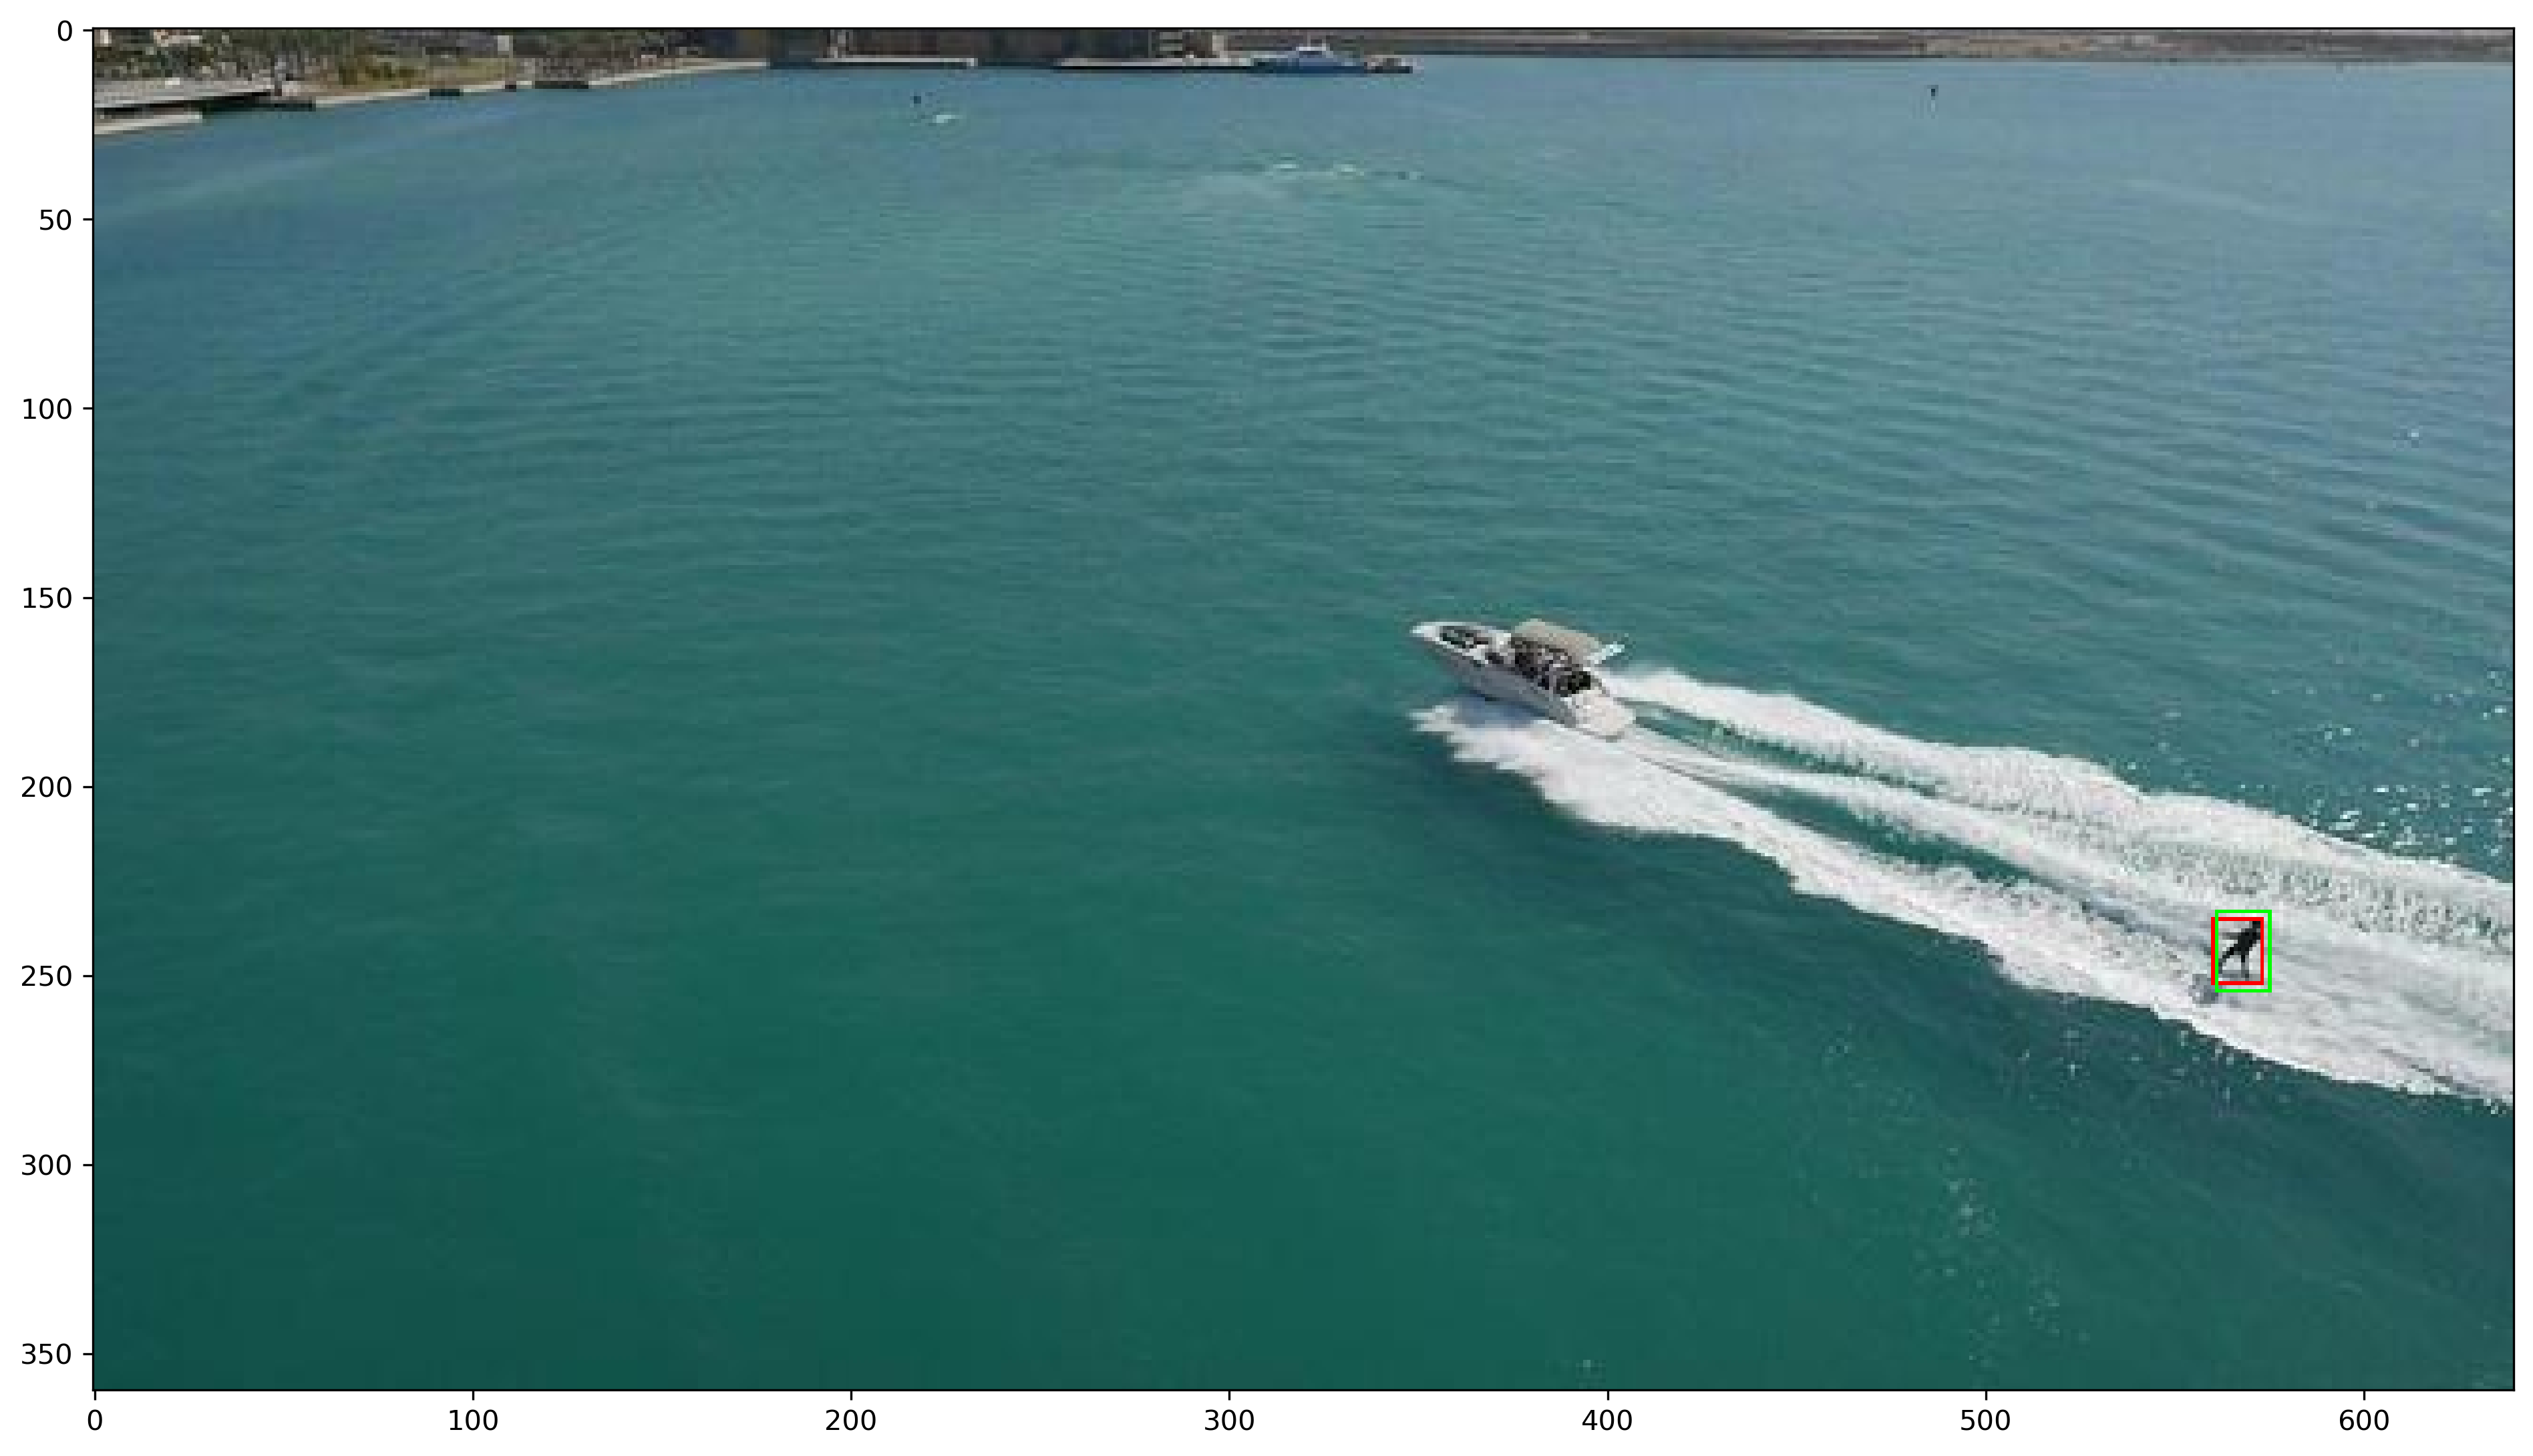

In [13]:
input_img = load_input('src/images/2.jpg')
output = get_box(model.predict(input_img).transpose(0,3,1,2))
truth = [0.88515625, 0.6763888888888889, 0.0203125, 0.04722222222222222]

truth_top_left = (int((truth[0] - truth[2]/2)*640), int((truth[1] + truth[3]/2)*360))
truth_bot_right = (int((truth[0] + truth[2]/2)*640), int((truth[1] - truth[3]/2)*360))

box_top_left = (int((output[0] - output[2]/2)*640), int((output[1] + output[3]/2)*360))
box_bot_right = (int((output[0] + output[2]/2)*640), int((output[1] - output[3]/2)*360))

input_img = Image.open('src/images/2.jpg')

draw = ImageDraw.ImageDraw(input_img)
draw.rectangle((truth_top_left, truth_bot_right), outline = (255,0,0))
draw.rectangle((box_top_left, box_bot_right), outline = (0,255,0))


plt.figure(1, figsize = (16, 9), dpi =300)
plt.imshow(input_img)
plt.show()